# Applying Gaussian Coupola SDG Method on Law School Admissions Bar Passage Dataset



## Description of the nootebook

In this notebook, synthetic data is generated for Law School Admissions dataset. A Law School Admissions dataset from the Law School Admissions Council (LSAC). From 1991 through 1997, LSAC tracked some twenty-seven thousand law students through law school, graduation, and sittings for bar exams. The result was the most comprehensive database that exists on the demography, experiences, and outcomes of a large cohort of aspiring lawyers. While the data has important limitations, it is a unique and very valuable source for studying a range of issues related to legal education. The dataset was originally collected for a study called 'LSAC National Longitudinal Bar Passage Study' by Linda Wightman in 1998.

##### dataset source: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage/data


## Table of contents

0. Import libraries and data
1. Data description
2. Data cleaning
3. Correlation plot
4. Creating metadata
5. Gaussian copula fitting
6. Evaluating produced synthetic data

## 0. Import libraries and data

In [1]:
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sdv.metadata import SingleTableMetadata, MultiTableMetadata
from sklearn.preprocessing import OneHotEncoder
from sdv.single_table import GaussianCopulaSynthesizer
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.visualization import get_column_plot,set_plotly_config
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdmetrics.single_table import BinaryAdaBoostClassifier, CategoricalCAP, CategoricalEnsemble, NumericalSVR
warnings.filterwarnings('ignore')

print('libraries imported')

libraries imported


In [2]:
#load the dataset
dataset_path = 'C:/Users/20181588/Desktop/AA SDG/synthetic-data-generation/Law School Admissions Bar Passage/Dataset/bar_pass_prediction.csv'
original_data = pd.read_csv(dataset_path)
# Make a copy of the dataset
data_full = original_data.copy()

There are many features but we will keep only the following in the upcoming exploration:

ugpa - This one stands for undergraduate gpa. Every other feature with gpa in it either perfectly correlates or perfectly negatively correlates with ugpa and this is the one I decided to keep.

decile1, decile1b, decile3 - These features represent the law school rankings by decile of each candidate in years 1 and 3 (and I’m assuming year one second semester, but I can’t be sure about that).

lsat - This feature is obviously the LSAT score of each candidate, but oddly it’s not formatted in the 120 to 180 score range of the actual LSAT. That said it has a strong correlation to whether someone passed the bar and, well, the feature is called lsat!

grad - This seems to be whether the student who took the bar exam graduated from law school. It’s a binary variable and there are very few 0s, so that makes the most sense. (Special kudos to the 65 students surveyed who didn’t graduate law school, but still managed to pass the bar!)

fulltime - Was the student a full-time student.

fam_inc - This feature is family income by quintile.

tier - What tier law school did the student attend by quintile.

race1 - Categorizes students by race. Of all the race variables this was the most complete, so it’s the one I kept. All the information contained in the other race variables are contained in race1.

sex - student gender.

pass_bar - This is the target variable. Did the student pass the bar.

## 1. Data description

In [3]:
# Check all columns available
data_full.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')

In [4]:
# List of columns to keep
columns_to_keep = [
    'pass_bar',  'ugpa', 'decile1', 'decile1b',
    'decile3', 'lsat', 'grad', 'fulltime', 'fam_inc',
    'tier', 'race1', 'gender'
]



df = data_full[columns_to_keep]

In [5]:
# Check the shape and names of the columns left
print(df.shape)
print(df.columns)

(22407, 12)
Index(['pass_bar', 'ugpa', 'decile1', 'decile1b', 'decile3', 'lsat', 'grad',
       'fulltime', 'fam_inc', 'tier', 'race1', 'gender'],
      dtype='object')


## 2. Data cleaning

In [6]:
# Check how many rows with missing values are there
print(df.isnull().sum())


pass_bar       0
ugpa           0
decile1     1092
decile1b    1604
decile3     1604
lsat           0
grad           3
fulltime      34
fam_inc      289
tier          96
race1         16
gender         5
dtype: int64


In [7]:
# Inspect the dataframe
display(df.head())

,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,gender
0,1,3.5,10.0,10.0,10.0,44.0,Y,1.0,5.0,4.0,white,female
1,1,3.5,5.0,5.0,4.0,29.0,Y,1.0,4.0,2.0,white,female
2,1,3.5,3.0,3.0,2.0,36.0,Y,1.0,1.0,3.0,white,male
3,1,3.5,7.0,7.0,4.0,39.0,Y,1.0,4.0,3.0,white,male
4,1,3.5,9.0,9.0,8.0,48.0,Y,1.0,4.0,5.0,white,male


In [8]:
# Remove all rows with missing values
initial_row_count = df.shape[0]
df = df.dropna()
removed_rows = initial_row_count - df.shape[0]
print(f"Removed {removed_rows} rows with missing values.")

Removed 1895 rows with missing values.


In [9]:
# Check if all the rows with missing values are removed
print(df.shape)
print(df.columns)
print(df.isnull().sum())


(20512, 12)
Index(['pass_bar', 'ugpa', 'decile1', 'decile1b', 'decile3', 'lsat', 'grad',
       'fulltime', 'fam_inc', 'tier', 'race1', 'gender'],
      dtype='object')
pass_bar    0
ugpa        0
decile1     0
decile1b    0
decile3     0
lsat        0
grad        0
fulltime    0
fam_inc     0
tier        0
race1       0
gender      0
dtype: int64


In [10]:
# Inspect the dataframe
display(df.head())

,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,gender
0,1,3.5,10.0,10.0,10.0,44.0,Y,1.0,5.0,4.0,white,female
1,1,3.5,5.0,5.0,4.0,29.0,Y,1.0,4.0,2.0,white,female
2,1,3.5,3.0,3.0,2.0,36.0,Y,1.0,1.0,3.0,white,male
3,1,3.5,7.0,7.0,4.0,39.0,Y,1.0,4.0,3.0,white,male
4,1,3.5,9.0,9.0,8.0,48.0,Y,1.0,4.0,5.0,white,male


#### Convert ordinal numerical columns to catagorical

In [11]:
# Check types of columns
print(df.dtypes)

pass_bar      int64
ugpa        float64
decile1     float64
decile1b    float64
decile3     float64
lsat        float64
grad         object
fulltime    float64
fam_inc     float64
tier        float64
race1        object
gender       object
dtype: object


In [12]:
# Columns to convert to categorical
columns_to_convert = ['grad', 'race1', 'gender','decile1', 'decile1b', 'decile3', 'fulltime', 'fam_inc', 'tier']

# Convert columns to categorical
for column in columns_to_convert:
    df[column] = df[column].astype('category')

# Verify changes
print(df.dtypes)

pass_bar       int64
ugpa         float64
decile1     category
decile1b    category
decile3     category
lsat         float64
grad        category
fulltime    category
fam_inc     category
tier        category
race1       category
gender      category
dtype: object


In [13]:
# Which colums are categorical
categorical_columns = df.select_dtypes(include=['category'])
print(categorical_columns.columns)

Index(['decile1', 'decile1b', 'decile3', 'grad', 'fulltime', 'fam_inc', 'tier',
       'race1', 'gender'],
      dtype='object')


## 3. Correlation plot

#### Distinguish cetegorical and numerical columns

In [14]:
# Select only the categorical columns
categorical_columns = df.select_dtypes(include=['category'])

# Loop through each categorical column and print value counts
for column in categorical_columns.columns:
    print(f"Value counts for column '{column}':")
    print(df[column].value_counts())

Value counts for column 'decile1':
decile1
6.0     2183
5.0     2180
7.0     2174
8.0     2166
9.0     2161
10.0    2136
4.0     2113
3.0     2063
2.0     1912
1.0     1424
Name: count, dtype: int64
Value counts for column 'decile1b':
decile1b
5.0     2092
7.0     2080
6.0     2079
9.0     2073
8.0     2069
3.0     2054
4.0     2046
10.0    2038
2.0     2032
1.0     1949
Name: count, dtype: int64
Value counts for column 'decile3':
decile3
5.0     2093
7.0     2082
9.0     2081
4.0     2077
3.0     2070
6.0     2067
8.0     2054
10.0    2029
2.0     2015
1.0     1944
Name: count, dtype: int64
Value counts for column 'grad':
grad
Y    20512
Name: count, dtype: int64
Value counts for column 'fulltime':
fulltime
1.0    19009
2.0     1503
Name: count, dtype: int64
Value counts for column 'fam_inc':
fam_inc
4.0    9076
3.0    7349
2.0    1987
5.0    1684
1.0     416
Name: count, dtype: int64
Value counts for column 'tier':
tier
3.0    7626
4.0    5717
5.0    3664
2.0    1629
6.0    1401
1.0 

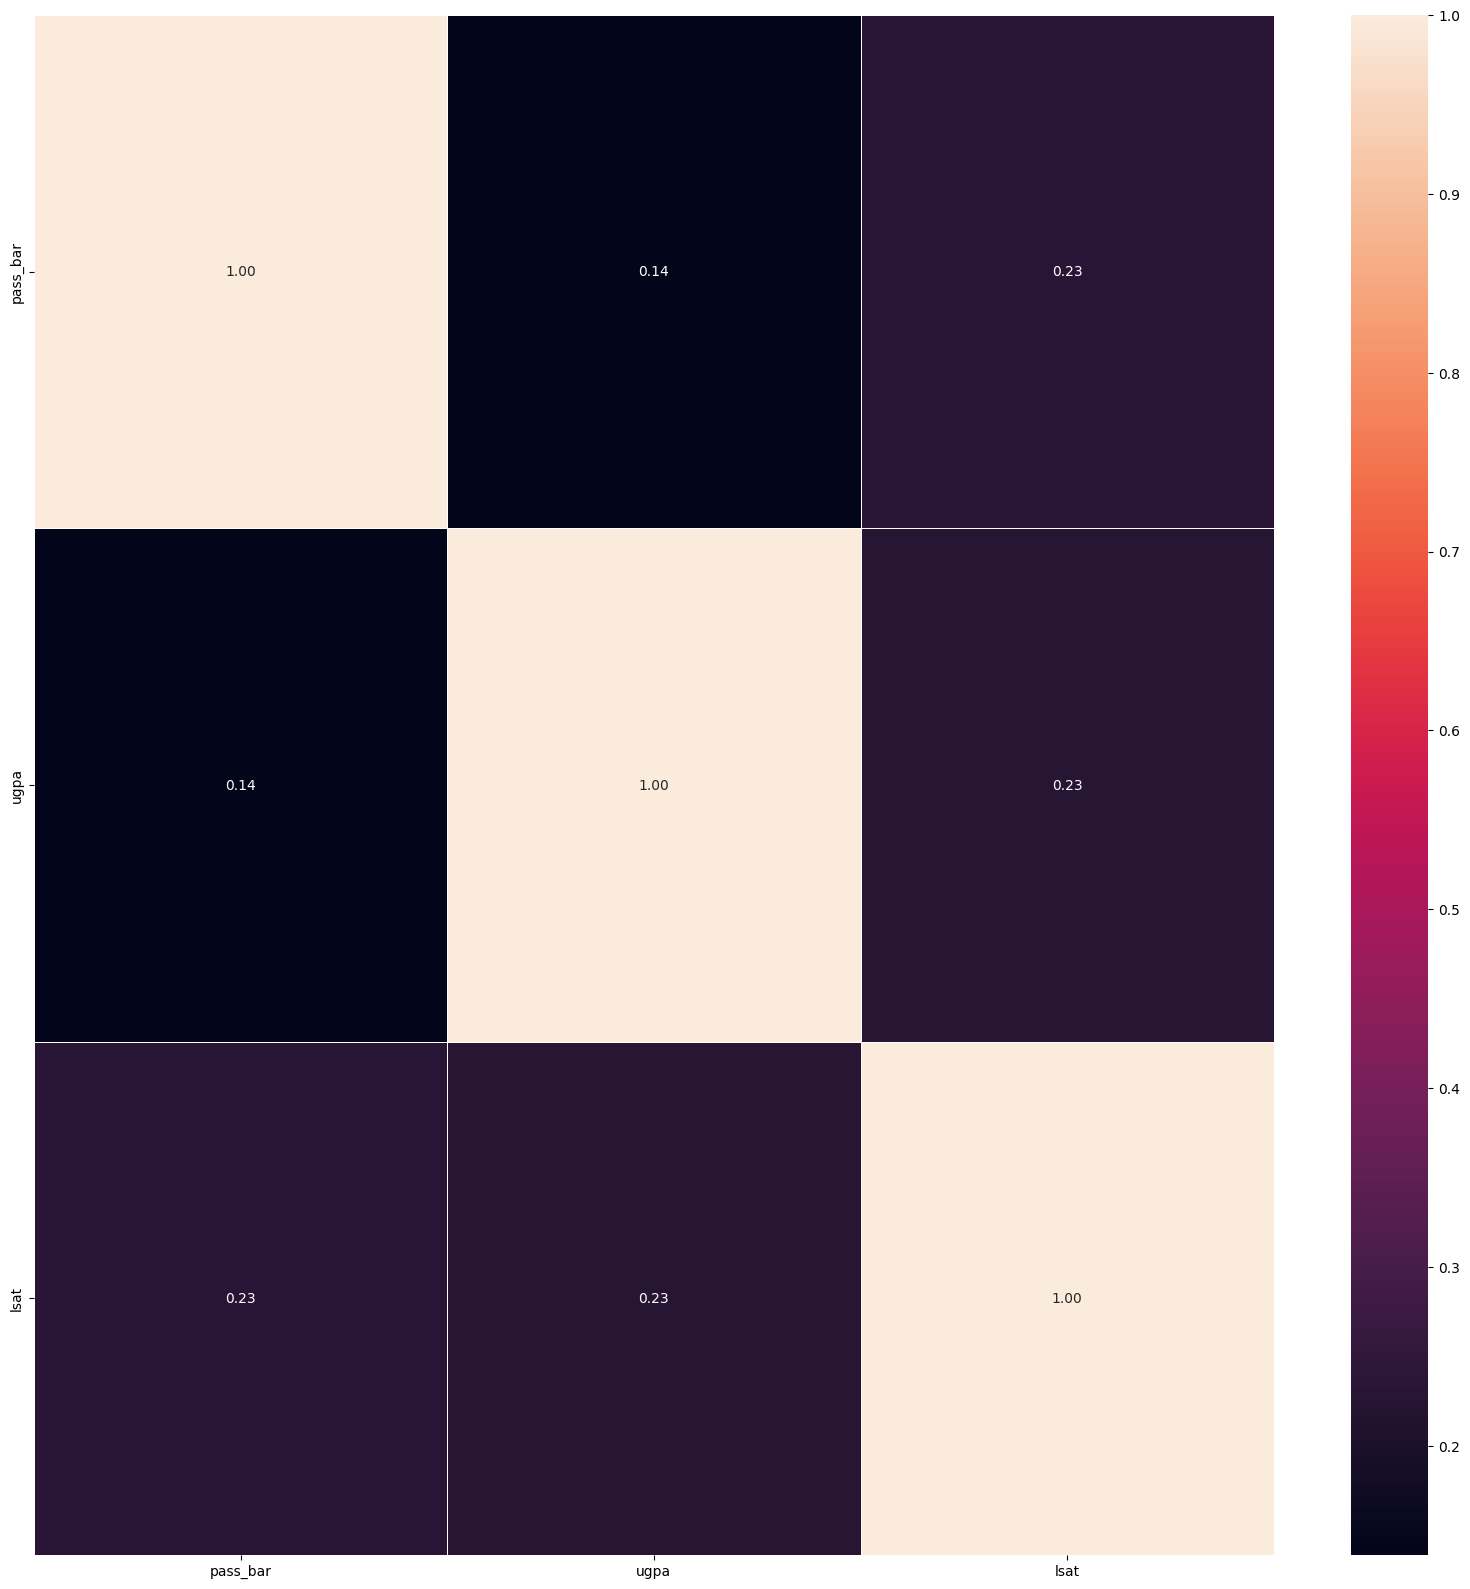

In [15]:
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df.corr(numeric_only=True), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

## 4. Creating metadata

In [16]:
# initializing metadata generator
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [17]:
metadata.validate()
metadata.save_to_json('PLA_metadata.json')

## 5. Gaussian Coupola fitting

Produce the synthetic data using a Gaussian Coupola

In [18]:
# GC fitting
synthesizer = GaussianCopulaSynthesizer(metadata,  default_distribution="gaussian_kde")
synthesizer.fit(df)

In [19]:
# create synthetic data and preview head
synthetic_data_GC = synthesizer.sample(num_rows=10000) # 20512 rows originally
synthetic_data_GC.head()

,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,gender
0,1,3.6,8.0,8.0,6.0,35.9,Y,1.0,4.0,3.0,white,female
1,1,3.0,8.0,9.0,1.0,31.6,Y,1.0,4.0,2.0,white,male
2,1,2.5,2.0,8.0,1.0,31.3,Y,1.0,2.0,3.0,white,male
3,1,3.4,3.0,9.0,10.0,35.0,Y,1.0,3.0,5.0,white,female
4,1,3.6,9.0,3.0,8.0,35.9,Y,1.0,3.0,5.0,white,male


In [20]:
# store synthetic data
synthetic_data_GC.to_csv('C:/Users/20181588/Desktop/AA SDG/synthetic-data-generation/Law School Admissions Bar Passage/Dataset/bar_pass_prediction_SD10k.csv')

## 6. Evaluating produced synthetic data

In [21]:
# check on structure of data
diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    metadata=metadata
)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 111.19it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%


In [22]:
# check on univariate and bivariate distributions
quality_report = evaluate_quality(
    df,
    synthetic_data_GC,
    metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 66/66 [00:01<00:00, 35.54it/s]

Overall Score: 79.03%

Properties:
- Column Shapes: 95.87%
- Column Pair Trends: 62.2%


In [23]:
# univariate quality report
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,pass_bar,TVComplement,0.998152
1,ugpa,KSComplement,0.993448
2,decile1,TVComplement,0.889946
3,decile1b,TVComplement,0.931489
4,decile3,TVComplement,0.913495
5,lsat,KSComplement,0.966437
6,grad,TVComplement,1.000000
7,fulltime,TVComplement,0.981926
8,fam_inc,TVComplement,0.949951
9,tier,TVComplement,0.950274


#### Categorical data

In [24]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='decile1'
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='decile1b'
)

fig.show()

In [ ]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='decile3'
)

fig.show()

In [25]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='grad'
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='fulltime'
)

fig.show()

In [ ]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='fam_inc'
)

fig.show()

In [ ]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='tier'
)

fig.show()

In [ ]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='race1'
)

fig.show()

In [ ]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='gender'
)

fig.show()

#### Statistical tests for univariate distributions

For the KS test, a high p-value (typically > 0.05) suggests no significant difference between the two distributions.For the Chi-squared test, a high p-value similarly suggests that the observed frequencies are not significantly different from the expected frequencies if the distributions were the same.

In [26]:
from scipy.stats import ks_2samp, chi2_contingency

# Define continuous variables
continuous_vars = ['ugpa', 'lsat']

# Apply KS test to continuous variables
for column in continuous_vars:
    ks_statistic, ks_p_value = ks_2samp(df[column], synthetic_data_GC[column])
    print(f"KS Statistic for {column}: {ks_statistic}, P-value: {ks_p_value}")

KS Statistic for ugpa: 0.006551638065522614, P-value: 0.933238435930991
KS Statistic for lsat: 0.033562558502340134, P-value: 5.151991834475064e-07


In [27]:
# Degfine categorical variables
categorical_vars = ['decile1', 'decile1b', 'decile3', 'grad', 'fulltime', 'fam_inc', 'tier', 'race1', 'gender']


# Apply Chi-squared test to categorical variables
for column in categorical_vars:
    # Create a contingency table
    contingency_table = pd.crosstab(df[column], synthetic_data_GC[column])
    
    # Run the Chi-squared test
    chi2_stat, chi2_p, dof, ex = chi2_contingency(contingency_table)
    print(f"Chi-squared Statistic for {column}: {chi2_stat}, P-value: {chi2_p}")

Chi-squared Statistic for decile1: 78.99692633866275, P-value: 0.5422782923688138
Chi-squared Statistic for decile1b: 81.64882524518825, P-value: 0.4588960420413921
Chi-squared Statistic for decile3: 70.51008882896652, P-value: 0.7909444429508657
Chi-squared Statistic for grad: 0.0, P-value: 1.0
Chi-squared Statistic for fulltime: 0.34541554598674973, P-value: 0.5567198219820353
Chi-squared Statistic for fam_inc: 18.61320780865563, P-value: 0.2892300569060842
Chi-squared Statistic for tier: 21.5903498229219, P-value: 0.6592742098634294
Chi-squared Statistic for race1: 12.252377220852344, P-value: 0.7264315231360851
Chi-squared Statistic for gender: 0.736548594559028, P-value: 0.39076873443714133


#### Dependency checks for multivariate distributions

In [28]:
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information between features and the target variable for the real data
real_mi = mutual_info_classif(df.drop('pass_bar', axis=1), df['pass_bar'])
# Do the same for the synthetic data
synthetic_mi = mutual_info_classif(synthetic_data_GC.drop('pass_bar', axis=1), synthetic_data_GC['pass_bar'])

# Combine into a DataFrame for easier comparison
mi_comparison = pd.DataFrame({'Real Data MI': real_mi, 'Synthetic Data MI': synthetic_mi}, 
                             index=df.drop('pass_bar', axis=1).columns)

print(mi_comparison)

ValueError: could not convert string to float: 'Y'

This comparison is useful because it tells how well the synthetic data preserves the statistical dependencies that exist in the real data. Ideally, the mutual information scores for each feature with the target variable should be similar between the real and synthetic datasets, indicating that the synthetic data maintains the same type of relationships as the original data. If there are significant discrepancies, this might suggest that the synthetic data generation process hasn't fully captured the complexity of the real data's structure, and further adjustments might be needed.